# iGIF dimensionality reduction

Ephys data suggest that there is substantial heterogeneity in DRN SOM neurons that's probably associated with distinct spiking patterns. In order to model this, we either need to create a suite of conductance-based models, or show that the iGIF can capture many different patterns.

Here, I try performing dimensionality reduction/clustering on iGIF parameters to see whether there's any evidence of:
1. Parameter clusters.
2. Distinct spiking patterns captured in different regions of parameter space spanned by our fitted models.

## Import modules

In [1]:
from __future__ import division

import os; os.chdir(os.path.join('..', '..', '..'))
os.getcwd()

'/Users/eharkin/Documents/School/Grad work/Thesis/Experiments/GIF fitting/GIF fitting project/GIFFittingToolbox'

In [2]:
import copy
import pickle
import re

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import pandas as pd
from sklearn.decomposition import PCA

from src.iGIF import iGIF
from src.Tools import timeToIntVec

## Load models

Unpickle iGIFs previously fitted to DRN **SOM** neurons.

In [3]:
DATA_PATH = os.path.join('data', 'models', 'GABA')

with open(os.path.join(DATA_PATH, 'gaba_igifs.mod'), 'rb') as f:
    iGIFs = pickle.load(f)
    f.close()

## Inspect model parameters

Extract and aggregate coefficients across models. Perform dimensionality reduction on extracted coefficients to look for patterns/clusters and map the parameter space spanned by fitted models. (In the next step, we'll look for subregions of the spanned parameter space associated with qualitatively different behaviours.)

In [4]:
def rescale_variables(x):
    """Subtract mean and normalize to SD for each column of a dataframe or array.
    Returns a copy.
    """
    output = np.copy(x)
    
    try:
        # Method for pd.DataFrames
        output.iloc # Test if x is DataFrame-like
        
        for colname in output:
            output[colname] = output[colname] - np.mean(output[colname])
            output[colname] = output[colname] / np.std(output[colname])
    
    except AttributeError:
        # Method for np.arrays.
        output[0, 0] # Test if x is array-like
        
        output -= output.mean(axis = 0)
        output /= output.std(axis = 0)
        
    return output

### Extract and analyze scalar parameters

The iGIF is composed of a set of scalar parameters $\{C, g_l, E_l, V_{reset}, V_T^*, \Delta V, \tau_\theta\}$ and three spike-triggered filters $\{\eta, \gamma, \theta\}$. First step is to look at the scalar parameters on their own.

In [5]:
igif_scalarparams = pd.DataFrame(columns = ['C', 'gl', 'El', 'Vr', 'Vt_star', 'DV', 'theta_tau'])
for mod in iGIFs:
    row_tmp = {}
    for colname in igif_scalarparams:
        row_tmp[colname] = [getattr(mod, colname)]
    igif_scalarparams = igif_scalarparams.append(pd.DataFrame(row_tmp), ignore_index = True)

In [6]:
igif_scalarparams.head()

,C,DV,El,Vr,Vt_star,gl,theta_tau
0,0.051189,2.113175,-48.430610,-43.533413,-56.425531,0.000927,4.641589
1,0.063793,1.867610,-69.092716,-58.726444,-67.986419,0.002950,10.000000
2,0.045139,2.064422,-47.099418,-49.961964,-57.183158,0.001458,4.641589
3,0.077043,1.271527,-73.045144,-63.719589,-65.404858,0.004807,4.641589
4,0.029731,2.262219,-65.166028,-59.491536,-56.050941,0.002755,10.000000


In [7]:
scalarparam_pca = PCA()
scalarparam_projection = scalarparam_pca.fit_transform(rescale_variables(igif_scalarparams))

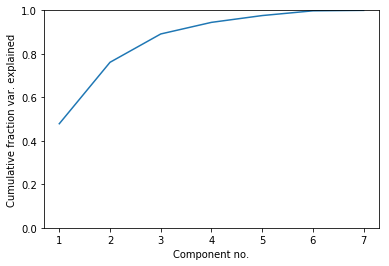

In [8]:
plt.figure()
plt.plot(
    np.arange(1, scalarparam_pca.n_components_ + 1), 
    np.cumsum(scalarparam_pca.explained_variance_ratio_)
)
plt.ylim(0, 1)
plt.ylabel('Cumulative fraction var. explained')
plt.xlabel('Component no.')
plt.show()

First two principal components explain most of the variance in scalar parameters.

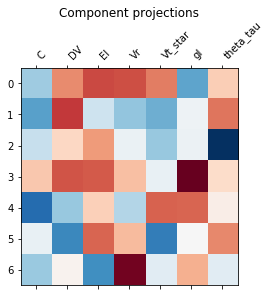

In [9]:
plt.figure()
ax = plt.subplot(111)
ax.set_title('Component projections', pad = 40)
ax.matshow(scalarparam_pca.components_, cmap = plt.get_cmap('RdBu'))
ax.set_xticks(np.arange(igif_scalarparams.shape[1]))
ax.set_xticklabels(igif_scalarparams.columns, rotation = 45, ha = 'left')
plt.show()

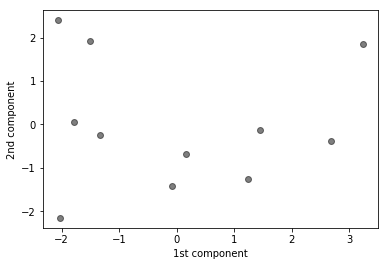

In [10]:
plt.figure()
plt.plot(
    scalarparam_projection[:, 0], 
    scalarparam_projection[:, 1], 
    'ko', alpha = 0.5
)
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.show()

### Extract and analyze filters

Each filter $\mathbf{k} \in \{\eta, \gamma, \theta\}$ is described by a vector of coefficients $\mathbf{k} = \begin{bmatrix} k_1 & k_2 & \cdots & k_N \end{bmatrix}$ that give the amplitude of the filter in each of $N$ time bins, voltage bins, the amplitude of exponential basis functions, etc. Here I do this in batch.

In [11]:
igif_filters = {}

# Extract eta and gamma coeffs using one method.
for filt in ['eta', 'gamma']:
    
    # Initialize array to hold coeffs.
    igif_filters[filt] = np.empty((len(iGIFs), len(getattr(iGIFs[0], filt).getCoefficients())))

    for i, mod in enumerate(iGIFs):
        igif_filters[filt][i, :] = getattr(mod, filt).getCoefficients()
        
# Extract theta coeffs using another method.
igif_filters['theta'] = np.empty((len(iGIFs), len(iGIFs[0].theta_i)))
igif_filters['theta_bins'] = np.empty((len(iGIFs), len(iGIFs[0].theta_bins)))
for i, mod in enumerate(iGIFs):
    igif_filters['theta'][i, :] = mod.theta_i
    igif_filters['theta_bins'][i, :] = mod.theta_bins
    

In [12]:
filter_pcas = {}
filter_transforms = {}
for filtname, coeffs in igif_filters.iteritems():
    filter_pcas[filtname] = PCA()
    filter_transforms[filtname] = filter_pcas[filtname].fit_transform(coeffs)
    
    print '{} var. explained by first two components: {:.3f}'.format(
        filtname, filter_pcas[filtname].explained_variance_ratio_[:2].sum()
    )

theta var. explained by first two components: 0.973
eta var. explained by first two components: 0.972
gamma var. explained by first two components: 0.997
theta_bins var. explained by first two components: 1.000


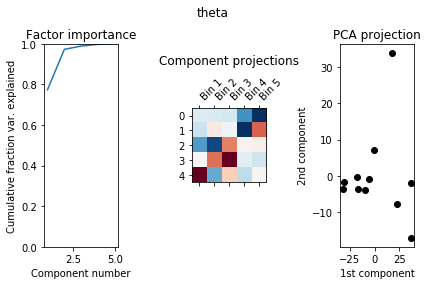

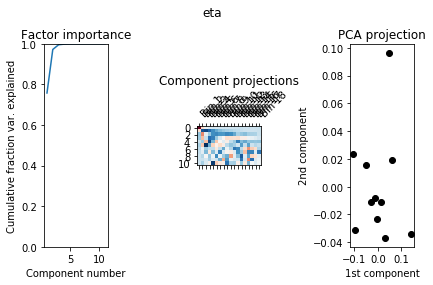

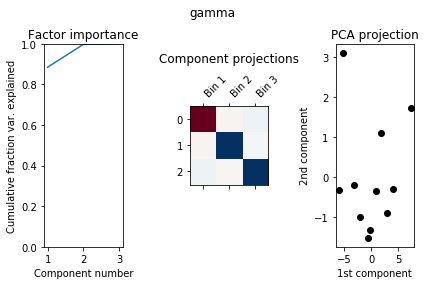

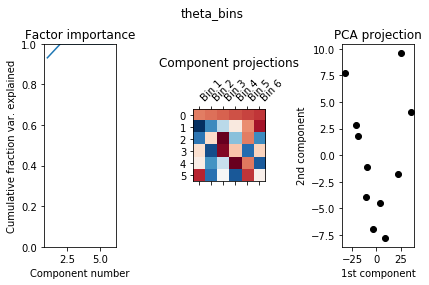

In [13]:
for filtname in filter_pcas.keys():
    plt.figure()
    plt.suptitle(filtname)
    
    ax_var = plt.subplot(131)
    ax_var.set_title('Factor importance')
    ax_var.plot(
        np.arange(1, len(filter_pcas[filtname].explained_variance_ratio_) + 1),
        np.cumsum(filter_pcas[filtname].explained_variance_ratio_)
    )
    ax_var.set_ylim(0, 1)
    ax_var.set_xlabel('Component number')
    ax_var.set_ylabel('Cumulative fraction var. explained')
    
    ax_project = plt.subplot(132)
    ax_project.set_title('Component projections', pad = 40)
    ax_project.matshow(
        filter_pcas[filtname].components_, 
        cmap = plt.get_cmap('RdBu')
    )
    ax_project.set_xticks(np.arange(filter_pcas[filtname].n_components_))
    ax_project.set_xticklabels(
        ['Bin {}'.format(i) for i in range(1, filter_pcas[filtname].n_components_ + 1)],
        rotation = 45, ha = 'left'
    )
    
    ax_transform = plt.subplot(133)
    trans = filter_transforms[filtname]
    
    ax_transform.set_title('PCA projection')
    ax_transform.plot(trans[:, 0], trans[:, 1], 'ko')
    ax_transform.set_xlabel('1st component')
    ax_transform.set_ylabel('2nd component')
    
    plt.tight_layout()
    plt.subplots_adjust(top = 0.85)
    
    plt.show()

Looks like the shape of eta is mainly determined by the first couple of components, and especially the amplitude ratios of the first bin and the rest of the components.

### Examine eta

In [14]:
test_etafilt = copy.deepcopy(iGIFs[0].eta)

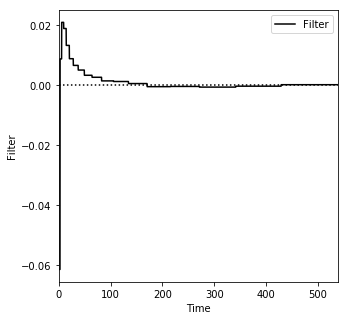

In [15]:
test_etafilt.setFilter_Coefficients(
    filter_pcas['eta'].components_[0, :] * 0.05 
    + filter_pcas['eta'].components_[1, :] * 0.05
)
test_etafilt.plot()

Playing with the values on the right in the above cell we can look at the shape of the eta kernel in different subregions of parameter space spanned by the first two principal components.

In about half of the parameter space eta has a biphasic shape, but it can also be a monophasic inward or outward current in about 25% of parameter space each. This indicates:
1. The shape of $\eta$ can vary a lot between cells.
2. Some cells have an ADP-like component in their $\eta$ kernel while others do not.
    1. This could lead to a subset of cells firing bursts.

### Perform PCA on all parameters together

Differences in scalar parameters or other filters could cancel out any effect of heterogeneity in $\eta$ on firing patterns. To find out whether this is the case, we have to build iGIFs based on the principal components of all model parameters taken together.

First, aggregate all model coefficients into a single dataframe for PCA.

In [16]:
master_df = igif_scalarparams.copy()

for filtname in igif_filters.keys():
    tmp = pd.DataFrame(igif_filters[filtname])
    tmp.rename({i: '{} {}'.format(filtname, i) for i in range(tmp.shape[1])}, axis = 1, inplace = True)
    master_df = pd.concat([master_df, tmp], axis = 1)

In [17]:
master_df.head()

,C,DV,El,Vr,Vt_star,gl,theta_tau,theta 0,theta 1,theta 2,...,eta 17,gamma 0,gamma 1,gamma 2,theta_bins 0,theta_bins 1,theta_bins 2,theta_bins 3,theta_bins 4,theta_bins 5
0,0.051189,2.113175,-48.430610,-43.533413,-56.425531,0.000927,4.641589,6.062063,11.262414,22.280505,...,0.001353,6.218837,1.105863,0.040153,-43.033413,-37.066476,-31.099538,-25.132601,-19.165664,86.801274
1,0.063793,1.867610,-69.092716,-58.726444,-67.986419,0.002950,10.000000,4.867541,8.374834,15.331407,...,0.000219,13.049067,1.295323,-0.025224,-58.226444,-50.713892,-43.201339,-35.688787,-28.176234,79.336318
2,0.045139,2.064422,-47.099418,-49.961964,-57.183158,0.001458,4.641589,4.596698,6.957851,15.150730,...,0.000915,7.372945,0.159222,0.051068,-49.461964,-42.332666,-35.203369,-28.074071,-20.944773,86.184524
3,0.077043,1.271527,-73.045144,-63.719589,-65.404858,0.004807,4.641589,4.911434,5.470836,10.974097,...,0.000438,9.210308,0.508555,0.091470,-59.079279,-53.371963,-47.664647,-41.957331,-36.250015,69.457301
4,0.029731,2.262219,-65.166028,-59.491536,-56.050941,0.002755,10.000000,13.439805,4.701839,17.491211,...,-0.000301,7.655197,-0.032927,-0.090037,-54.588992,-47.723156,-40.857320,-33.991485,-27.125649,79.740187


Perform PCA on *rescaled* variables using `sklearn.decomposition.PCA`. Right now, each column in `master_df` is standardized separately, ie $Z^{(\eta)}_{ij} = \frac{\eta_{ij} - \mu_j}{\sigma_j}$. Maybe it would be more appropriate to standardize all filter terms together? e.g. $Z^{(\eta)}_{ij} = \frac{\eta_{ij} - \mu^{(\eta)}}{\sigma^{(\eta)}}$ where $\mu^{(\eta)} = \frac{1}{N_i N_j}\sum_i\sum_j\eta_{ij}$.

In [18]:
master_pca = PCA()
master_transform = master_pca.fit_transform(rescale_variables(master_df))

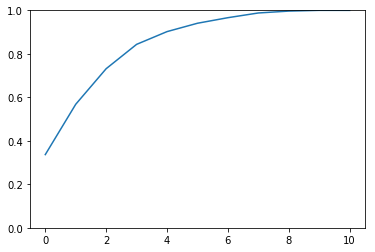

In [19]:
plt.figure()
plt.subplot(111)
plt.plot(np.cumsum(master_pca.explained_variance_ratio_))
plt.ylim(0, 1)
plt.show()

Plot of cumulative fraction variance explained for principal components. First 3-4 are important.

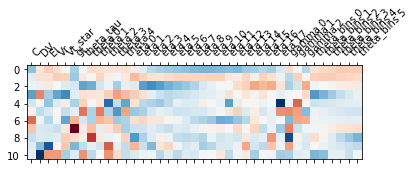

In [20]:
plt.figure()
ax = plt.subplot(111)
ax.matshow(master_pca.components_, cmap = plt.get_cmap('RdBu'))
ax.set_xticks(np.arange(0, master_df.shape[1]))
ax.set_xticklabels(master_df.columns, rotation = 45, ha = 'left')
plt.show()

Plot of iGIF coefficient principal components. Note the stereotyped shapes of the spike-triggered current kernel $\eta$ captured by the first few components.

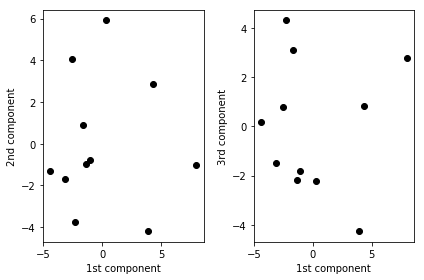

In [21]:
plt.figure()
plt.subplot(121)
plt.plot(master_transform[:, 0], master_transform[:, 1], 'ko')
plt.xlabel('1st component')
plt.ylabel('2nd component')

plt.subplot(122)
plt.plot(master_transform[:, 0], master_transform[:, 2], 'ko')
plt.xlabel('1st component')
plt.ylabel('3rd component')

plt.tight_layout()

plt.show()

Looks like the models are spread out pretty evenly across the first few components... No obvious clustering here. 

## Search for model 'types'

In the previous section we see that the coefficients used to specify the iGIFs are pretty evenly spready out. Could still be that different regions of parameter space lead to qualitatively-distinct behaviour, though.

To find out whether this is the case, try building iGIFs in regions of parameter space spanned by our fitted iGIFs and look at their firing patterns.

### Write utility functions to build and inspect iGIFs

In [22]:
def descale_variables(x, raw_variables):
    """Perform inverse of rescale_variables on x using statistics computed on raw_variables.
    """
    
    x = np.copy(x)
    
    x *= np.std(raw_variables, axis = 0)
    x += np.mean(raw_variables, axis = 0)
    
    return x

In [23]:
# Function to generate iGIF at particular coordinates in parameter space.
def iGIF_from_PCA(percentiles, components, transformed_variables, raw_variables, base_iGIF):
    """Construct a new iGIF from base_iGIF based on the PCA components of raw_variables.
    """
    
    mag_tmp = []
    for i, scalar in enumerate(percentiles):
        mag_tmp.append(np.percentile(transformed_variables[:, i], scalar))

    mag_tmp = np.array(mag_tmp)
    modcoeffs_scaled = np.dot(components[:len(percentiles), :].T, mag_tmp)

    modcoeffs = descale_variables(modcoeffs_scaled, raw_variables)
    
    # Construct new model from base_iGIF using coeffs from modcoeffs.
    pctilemod = copy.deepcopy(base_iGIF)

    for attr_ in ['gl', 'C', 'DV', 'El', 'Vr', 'Vt_star', 'theta_tau']:
        setattr(pctilemod, attr_, modcoeffs[attr_])

    eta_tmp = []
    for attr_ in re.findall(r'\beta [0-9]+\b', ' '.join(modcoeffs.keys())):
        eta_tmp.append(modcoeffs[attr_])

    pctilemod.eta.setFilter_Coefficients(eta_tmp)
    del eta_tmp

    gamma_tmp = []
    for attr_ in re.findall(r'\bgamma [0-9]+\b', ' '.join(modcoeffs.keys())):
        gamma_tmp.append(modcoeffs[attr_])
    pctilemod.gamma.setFilter_Coefficients(gamma_tmp)
    del gamma_tmp

    theta_tmp = {'i': [], 'bins': []}
    for attr_ in re.findall(r'\btheta [0-9]+\b', ' '.join(modcoeffs.keys())):
        theta_tmp['i'].append(modcoeffs[attr_])
    pctilemod.theta_i = np.array(theta_tmp['i'])
    for attr_ in re.findall(r'\btheta_bins [0-9]+\b', ' '.join(modcoeffs.keys())):
        theta_tmp['bins'].append(modcoeffs[attr_])
    pctilemod.theta_bins = np.array(theta_tmp['bins'])
    del theta_tmp
    
    return pctilemod

In [24]:
# Function to quickly inspect generated models.
def plot_spiking_phenotype(mod, step_ampli = 0.05, no_reps = 200, no_bins = 20, kernel_len = 10.):
    """
    Inputs:
        mod          -- iGIF
            Model to use for simulations.
        step_ampli   -- float
            Current step amplitude in nA.
        no_reps      -- int
            Sample size for ISI hist and PSTH.
        no_bins      -- int
            Number of histogram bins.
        kernel_len   -- float
            Length of rect. kernel to use for PSTH.
    """

    I = np.concatenate([np.zeros(5000), step_ampli * np.ones(20000)])
    bins = np.logspace(0, np.log2(1000), no_bins, base = 2)

    spks = []
    for i in range(no_reps):
        t, V, eta, V_T, spks_tmp = mod.simulate(I, mod.El)
        spks.append(spks_tmp)

    plt.figure()

    pctile_spec = gs.GridSpec(2, 2, height_ratios = [1, 0.6], width_ratios = [1, 0.6])

    # Plot a sample trace.
    plt.subplot(pctile_spec[0, 0])
    plt.title('Trace')
    plt.plot(t, V, 'k-')
    plt.xlim(t[0], t[-1])
    plt.ylabel('V (mV)')
    plt.xticks([])

    # Plot PSTH and raster plot.
    plt.subplot(pctile_spec[1, 0])
    plt.title('PSTH and raster')
    spkvec = timeToIntVec(spks[0], t[-1] + mod.dt, mod.dt) # Int vec to use for PSTH
    for i, spktrain in enumerate(spks):
        if i < 20:
            plt.plot(spktrain, i * np.ones_like(spktrain), 'k|', markersize = 2)
        
        if i > 0:
            spkvec += timeToIntVec(spks[i], t[-1] + mod.dt, mod.dt)
        
    plt.plot(
        t, np.convolve(spkvec, np.ones(int(kernel_len / mod.dt))/kernel_len, mode = 'same'),
        'g-'
    )
    plt.xlim(t[0], t[-1])
    plt.ylabel('Pop. f. rate (Hz neuron$^{-1}$)')

    # Extract ISI distribution.
    ISI_dist = []
    for spktrain in spks:
        ISI_dist.append(np.diff(spktrain))
    ISI_dist = np.concatenate(ISI_dist)

    # Plot ISI histogram.
    plt.subplot(pctile_spec[:, 1])
    plt.title('ISI histogram')
    plt.hist(ISI_dist, bins = bins)
    plt.xscale('log')
    plt.ylabel('Count')
    plt.xlabel('ISI (ms)')
    
    plt.tight_layout()

    plt.show()

Crude test of utility functions: build a test model and look at its parameters.

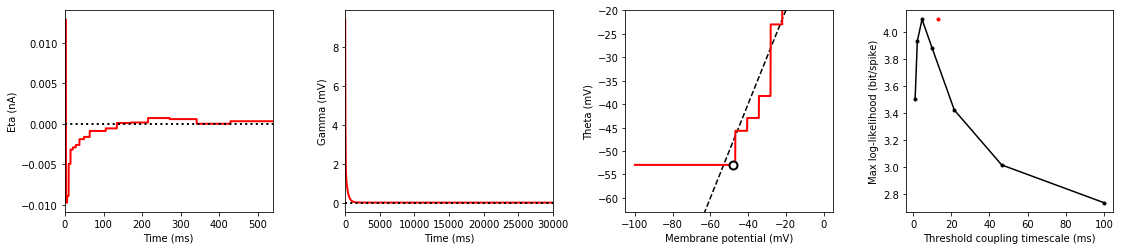


-------------------------
iGIF_NP model parameters:
-------------------------
tau_m (ms):	35.872
R (MOhm):	600.002167
C (nF):		0.060
gl (nS):	0.002
El (mV):	-57.075
Tref (ms):	4.000
Vr (mV):	-47.826
Vt* (mV):	-52.965
DV (mV):	1.968
tau_theta (ms):	13.254
-------------------------



In [25]:
pctilemod = iGIF_from_PCA([50, 25, 50], master_pca.components_, master_transform, master_df, iGIFs[0])
pctilemod.plotParameters()
pctilemod.printParameters()
del pctilemod

### Generate and inspect models

First, generate a reference model right in the middle of the parameter space spanned by the first few components.

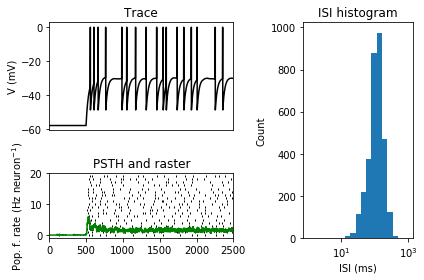

In [26]:
plot_spiking_phenotype(
    iGIF_from_PCA([50, 50, 50], master_pca.components_, master_transform, master_df, iGIFs[0])
)

Generate models in different corners of parameter space.

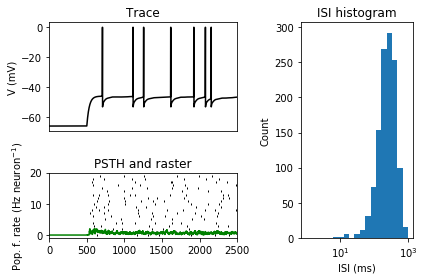

In [27]:
plot_spiking_phenotype(
    iGIF_from_PCA([75, 50, 50], master_pca.components_, master_transform, master_df, iGIFs[0])
)

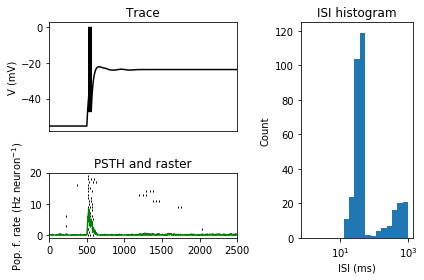

In [28]:
plot_spiking_phenotype(
    iGIF_from_PCA([25, 50, 50], master_pca.components_, master_transform, master_df, iGIFs[0])
)

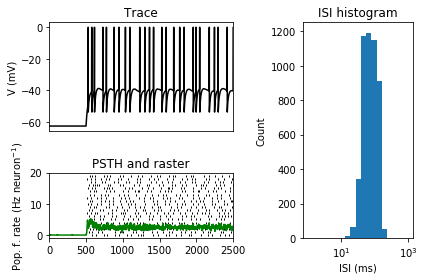

In [29]:
plot_spiking_phenotype(
    iGIF_from_PCA([50, 75, 50], master_pca.components_, master_transform, master_df, iGIFs[0])
)

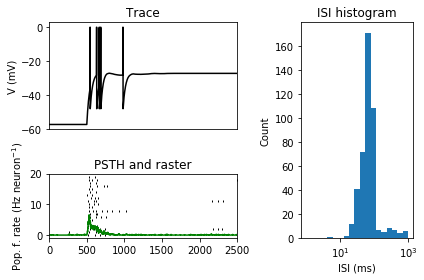

In [30]:
plot_spiking_phenotype(
    iGIF_from_PCA([50, 25, 50], master_pca.components_, master_transform, master_df, iGIFs[0])
)

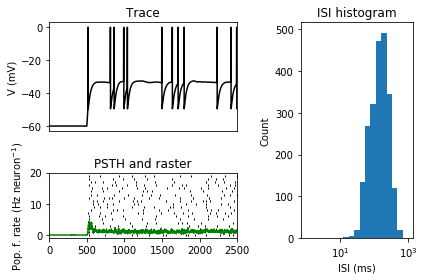

In [31]:
plot_spiking_phenotype(
    iGIF_from_PCA([50, 50, 75], master_pca.components_, master_transform, master_df, iGIFs[0])
)

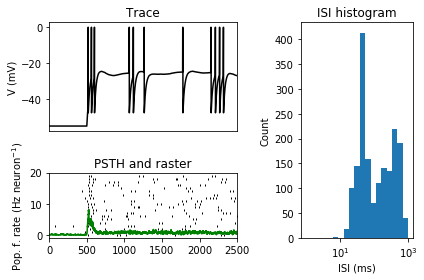

In [32]:
plot_spiking_phenotype(
    iGIF_from_PCA([50, 50, 25], master_pca.components_, master_transform, master_df, iGIFs[0])
)

Clearly some neurons are more susceptible to depolarization block than others, or have higher/lower threshold, higher/lower $V_{rest}$, etc. However, at least some of these results are probably only true within narrow input ranges. No easy answers, unfortunately, and future analysis will have to look at multiple input strengths.